# Decision tree classifier
The notebook describes the decision tree classifier for the model that is being used to get the first pass of potential variables for use in the model.

Decision Trees (DTs) are a supervised learning approach that predict target values (endogenous or dependent variables) of responses by deriving information from the features (exogenous or explanatory variables). They can be used in both a regression and a classification context. Classification problems for decision trees are often binary - here we are predicting performance vs. non-performance.

Given the loan performance data derived from the previous workbook, the loan specific performance information can help us determine behaviors that can describe good and bad loans, or `PERFORMANCE`.  By dividing the data set into smaller data sets based on the descriptive features, the algorithm iterates until it identifies a small sample containing all data points that fall under one label. Then each feature in the data set becomes a root with leafs as nodes representing the outcomes. 

Some of the benefits of the approach are:
- Ease of interpretation 
- Requires limited data preparation
- No need to normalize or scale the data

At the same time:
- The risk of overfitting is real
- Complex trees are more likely to overfit

This can be counterbalanced by limiting the tree depth.  Pre-pruning sets the parameters of a decision tree before modeling it by setting the:
- Maximum tree depth
- Maximum number of  nodes
- Minimum samples at a node split, which controls the size of the terminal nodes
- Maximum number of features

Given this, the model here will start with the full dataset and limited number of leaves and sets a high splitting threshold.

In [114]:
# JUNE 24, 2019 -- Rerun
# IMPLEMENTING A DECISION TREE MODEL 2019-06-16 15:14:38
# run on 2019-06-17 11:44:17 without the Vinatge to get the relationship
# run on 2019-06-17 13:42:44 without the oversamling ---SMOTE

# Preliminary work and data manipulation
Reads in data and sets global parameters

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=12)
plt.rcParams["figure.figsize"] = (10, 10)
plt.style.use('fivethirtyeight')
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Reads in necessary libraries for  DecisionTreeClassifier and RandomForestClassifier

In [265]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

In [266]:
!pwd

/Users/alderaan/Documents/PROJECTS_INSIGHT/code_files/Code_good


I read in the full data set and run some simple checks.

In [267]:
# reads in data
data_in = pd.read_csv('data/full_data.csv')

There are two switches here: 
- to create a deepcopy as a backup for the data to save time when it needs to be read in 
- to invoke a sample function to reduce the number of observations to accelerate the walkthrough if needed.  
They are marked.

Some data quality observations:
- `home_ownership` needs to be converted into categorical variables: `OWN`, `RENT`, `MORTGAGE`, and `OTHER`.
- `purpose` needs to be converted into categorical variables: `car`, `credit_card`, `debt_consolidation`, `educational`, `home_improvement`, `house`, `major_purchase`,`medical`, `moving`, `other`,`renewable_energy`, `small_business`, `vacation`, `wedding`

In [310]:
# I run a deep copy to make sure that there is a backup
import copy
data1 = copy.deepcopy(data_in)  # creates backup dat
# can create a sample of 10% of observations to make the process faster. Results are full
#data1 = data1.sample(frac=0.1)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2376343 entries, 0 to 2376342
Data columns (total 81 columns):
Unnamed: 0                        int64
mo_sin_old_il_acct                float64
total_rec_prncp                   float64
bc_util                           float64
home_ownership                    object
loan_amnt                         float64
dti                               float64
collection_recovery_fee           float64
tot_cur_bal                       float64
delinq_2yrs                       float64
acc_open_past_24mths              float64
pub_rec                           float64
int_rate                          float64
tot_coll_amt                      float64
num_op_rev_tl                     float64
chargeoff_within_12_mths          float64
mort_acc                          float64
total_rec_late_fee                float64
il_util                           float64
num_rev_accts                     float64
num_bc_tl                         float64
mths_sin

Adding variables specifically for `home ownership` and `purpose`.  Historically, and also evidenced by the data, these variables have some explanatory contribution to default.

In [311]:
data1 = pd.concat([data1.drop('home_ownership', axis=1),
                   pd.get_dummies(data1['home_ownership'])], axis=1)
data1 = pd.concat([data1.drop('purpose', axis=1),
                   pd.get_dummies(data1['purpose'])], axis=1)
data1.columns

Index(['Unnamed: 0', 'mo_sin_old_il_acct', 'total_rec_prncp', 'bc_util',
       'loan_amnt', 'dti', 'collection_recovery_fee', 'tot_cur_bal',
       'delinq_2yrs', 'acc_open_past_24mths', 'pub_rec', 'int_rate',
       'tot_coll_amt', 'num_op_rev_tl', 'chargeoff_within_12_mths', 'mort_acc',
       'total_rec_late_fee', 'il_util', 'num_rev_accts', 'num_bc_tl',
       'mths_since_recent_inq', 'total_rev_hi_lim', 'open_act_il',
       'mths_since_recent_bc', 'avg_cur_bal', 'inq_last_6mths', 'Maturity',
       'open_rv_24m', 'all_util', 'delinq_amnt', 'total_rec_int', 'max_bal_bc',
       'acc_now_delinq', 'funded_amnt_inv', 'revol_util', 'inq_last_12m',
       'last_pmt_year', 'mths_since_last_delinq', 'PERFORMING', 'open_il_24m',
       'mo_sin_old_rev_tl_op', 'fico_range_high', 'funded_amnt', 'revol_bal',
       'collections_12_mths_ex_med', 'recoveries', 'out_prncp',
       'num_actv_rev_tl', 'mths_since_last_major_derog', 'emp_length_int',
       'out_prncp_inv', 'mths_since_recent_rev

Dropping missing observations and missing data columns
1. _Columns_ - **feature variables** - with too many missing observations.  Criteria is to remove all columns with more than 5% of observations missing.
2. _Rows_ - **target variables** - with too many missing observations.  Criteria is to remove all columns with more than 5% of observations missing.

In [312]:
# identifying missing column observations
pct_null_col = data1.isnull().sum() / len(data1)
pct_null_col.sort_values(axis=0, ascending=False).head(25)

mths_since_last_record            0.843213
mths_since_recent_bc_dlq          0.771793
mths_since_last_major_derog       0.745082
mths_since_recent_revol_delinq    0.674603
mths_since_last_delinq            0.515204
il_util                           0.457076
mths_since_rcnt_il                0.384389
all_util                          0.364582
total_cu_tl                       0.364480
open_acc_6m                       0.364480
inq_last_12m                      0.364480
open_rv_24m                       0.364480
open_il_12m                       0.364480
total_bal_il                      0.364480
open_rv_12m                       0.364480
open_act_il                       0.364480
max_bal_bc                        0.364480
open_il_24m                       0.364480
mths_since_recent_inq             0.130365
mo_sin_old_il_acct                0.060003
bc_util                           0.032592
bc_open_to_buy                    0.032090
mths_since_recent_bc              0.031422
avg_cur_bal

In [313]:
# identifying columns with more than 5% of observations missing
missing_features = pct_null_col[pct_null_col > 0.05].index
print("Dropping the following columns:\n", missing_features)

Dropping the following columns:
 Index(['mo_sin_old_il_acct', 'il_util', 'mths_since_recent_inq', 'open_act_il',
       'open_rv_24m', 'all_util', 'max_bal_bc', 'inq_last_12m',
       'mths_since_last_delinq', 'open_il_24m', 'mths_since_last_major_derog',
       'mths_since_recent_revol_delinq', 'open_acc_6m',
       'mths_since_last_record', 'total_cu_tl', 'open_rv_12m', 'open_il_12m',
       'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'total_bal_il'],
      dtype='object')


In [314]:
# dropping columns with more than 5% of observations missing
data1.drop(missing_features, axis=1, inplace=True)
print("Dropped the following columns:\n", missing_features)

Dropped the following columns:
 Index(['mo_sin_old_il_acct', 'il_util', 'mths_since_recent_inq', 'open_act_il',
       'open_rv_24m', 'all_util', 'max_bal_bc', 'inq_last_12m',
       'mths_since_last_delinq', 'open_il_24m', 'mths_since_last_major_derog',
       'mths_since_recent_revol_delinq', 'open_acc_6m',
       'mths_since_last_record', 'total_cu_tl', 'open_rv_12m', 'open_il_12m',
       'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'total_bal_il'],
      dtype='object')


In [315]:
# identifying missing row observations
pct_null_row = data1.isnull().sum(axis=1) / len(data1.columns)
pct_null_row.sort_values(axis=0, ascending=False).head(25)

2039788    0.392405
2039704    0.392405
2039705    0.392405
2039735    0.392405
2039781    0.379747
2039776    0.379747
2039777    0.379747
2039778    0.379747
2039779    0.379747
2039780    0.379747
2039783    0.379747
2039782    0.379747
2039774    0.379747
2039784    0.379747
2039785    0.379747
2039786    0.379747
2039775    0.379747
2039772    0.379747
2039773    0.379747
2039789    0.379747
2039771    0.379747
2039770    0.379747
2039769    0.379747
2039764    0.379747
2039749    0.379747
dtype: float64

In [316]:
# identifying columns with the proportion of observations missing
print("The number of rows with more than 1% of recods missing is:",
      len(pct_null_row[pct_null_row > 0.010].index), "or",
      "{0:.2f}%".format(
          (len(pct_null_row[pct_null_row > 0.010].index)/len(pct_null_row))*100),
      "of observations.")
print("The number of rows with more than 5% of recods missing is:",
      len(pct_null_row[pct_null_row > 0.050].index), "or",
      "{0:.2f}%".format(
          (len(pct_null_row[pct_null_row > 0.050].index)/len(pct_null_row))*100),
      "of observations.")
print("The number of rows with more than 10% of recods missing is:",
      len(pct_null_row[pct_null_row > 0.10].index), "or",
      "{0:.2f}%".format(
          (len(pct_null_row[pct_null_row > 0.10].index)/len(pct_null_row))*100),
      "of observations.")
print("The number of rows with more than 20% of recods missing is:",
      len(pct_null_row[pct_null_row > 0.20].index), "or",
      "{0:.2f}%".format(
          (len(pct_null_row[pct_null_row > 0.20].index)/len(pct_null_row))*100),
      "of observations.")

missing_observations = pct_null_row[pct_null_row > 0.050].index

The number of rows with more than 1% of recods missing is: 101902 or 4.29% of observations.
The number of rows with more than 5% of recods missing is: 71836 or 3.02% of observations.
The number of rows with more than 10% of recods missing is: 70276 or 2.96% of observations.
The number of rows with more than 20% of recods missing is: 50316 or 2.12% of observations.


In [317]:
# dropping rows with more than 5% of records missing
data1.drop(missing_observations, axis=0, inplace=True)
#print("Dropped the following observations:\n", missing_observations)
print("The number of observations is now:", len(data1))

The number of observations is now: 2304507


## Defining variables for all the models
The data is split into the target variable and in various explanatory datasets with the objective of training a number of different datasets 

In [318]:
# Extract stuff
target = data1['PERFORMING']

features_full = data1[{'total_rec_prncp', 'bc_util', 'loan_amnt', 'dti',
                       'tot_cur_bal', 'delinq_2yrs',
                       'acc_open_past_24mths', 'pub_rec', 'int_rate', 'tot_coll_amt',
                       'num_op_rev_tl', 'chargeoff_within_12_mths', 'mort_acc',
                       'total_rec_late_fee', 'num_rev_accts', 'num_bc_tl', 'total_rev_hi_lim',
                       'mths_since_recent_bc', 'avg_cur_bal', 'inq_last_6mths', 'Maturity',
                       'delinq_amnt', 'total_rec_int', 'acc_now_delinq', 'funded_amnt_inv',
                       'revol_util', 'last_pmt_year', 'mo_sin_old_rev_tl_op',
                       'funded_amnt', 'revol_bal',
                       'collections_12_mths_ex_med', 'out_prncp',
                       'num_actv_rev_tl', 'emp_length_int', 'out_prncp_inv', 'num_il_tl',
                       'last_pymnt_amnt', 'total_acc', 'total_pymnt_inv',
                       'annual_inc', 'installment', 'num_bc_sats', 'bc_open_to_buy',
                       'open_acc', 'mo_sin_rcnt_tl',
                       'mo_sin_rcnt_rev_tl_op', 'CREDIT_HISTORY', 'num_accts_ever_120_pd',
                       'total_pymnt', 'num_actv_bc_tl', 'vintage',
                       'ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT', 'car', 'credit_card',
                       'debt_consolidation', 'educational', 'home_improvement', 'house',
                       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
                       'small_business', 'vacation', 'wedding'}]

features_full.sort_index(axis=1, inplace=True);
features_full.fillna(0, inplace=True);
features_full.isnull().any(axis=0);

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Splitting up the data into learning and testing.  The train test split is set at 20/80.

In [319]:
X_train, X_test, y_train, y_test = train_test_split(
    features_full, target, test_size=0.8, random_state=50)

## Oversampling
Given that the dataset contains 86% performing and 14% non-performing loans, it would make sense to create a more balanced dataset that includes an even number of performing and non-performing loans.

In [320]:
categorical = [0, 2, 4, 5, 6, 7, 14, 17, 18,
               22, 26, 27, 34, 35, 40, 51, 55, 58, 68, 70]

smnc = SMOTENC(categorical_features=categorical, random_state=12)
x_res, y_res = smnc.fit_sample(X_train, y_train)

## Scaling variables
For the Decision trees, scaling variables are not needed.  There is an argument for including scaling in Random Forest, which I will do.  My experience shows that the results are much better when the data is scaled using Robust Scaler, perhaps because the outliers drive the performance and default.

Adding a function for accuracy calculations.

In [321]:
def show_accuracy(model, X, y, model_name):
    pred = model.predict(X)
    print('Accuracy: {0:0.3f}'.format(accuracy_score(y, pred)))

    # predict probabilities & keep probabilities for the positive outcome only
    probs = model.predict_proba(X)[:, 1]
    tpr, fpr, _ = roc_curve(y, probs)
    roc_auc = roc_auc_score(y, probs)

    # plot the curve
    plt.plot(tpr, fpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0}: ROC curve AUC={1:0.3f}'.format(model_name, roc_auc))
    plt.show()

# The Decision Tree Model
The model is chosen because it produces an easily interpretable model: each of the leaf node is a representation of an if/then outcomes and the outcomes that meet the criteria are placed in the node.  Additionally, the model is non-parametric and does not require any normality assumptions of the data. Here, the relationship between the variables is to be understood as well and makes the non-parametric model useful. Finally, the model handles data of different types, such as continuous, categorical, and binary. 

Ultimately, the model is not implemented to make predictions about the variables that predict default, but rather to detect important variables and interactions.

## Decision tree classifier

Accuracy on training set: 0.981
Accuracy on test set: 0.980
Accuracy: 0.980


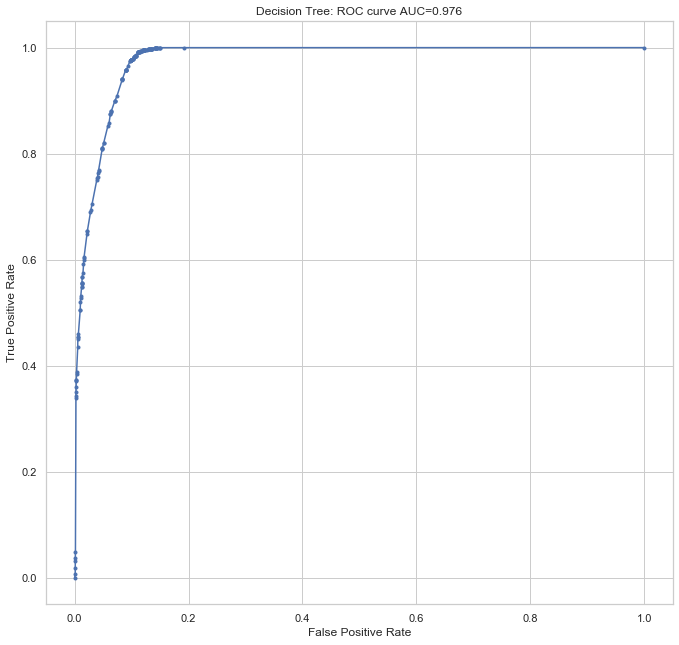

Best estimator DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [322]:
tree_para = {'criterion': ['gini', 'entropy'],
             'max_depth': [5, 10],
             'min_samples_leaf': [2, 3, 4, 5]}

tree = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=2)

tree.fit(x_res, y_res)

print("Accuracy on training set: {:.3f}".format(tree.score(x_res, y_res)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))
show_accuracy(tree, X_test, y_test, "Decision Tree")

y_pred = tree.predict(X_test)

print("Best estimator", tree.best_estimator_)

Accuracy on training set: 0.978
Accuracy on test set: 0.974
Accuracy: 0.974


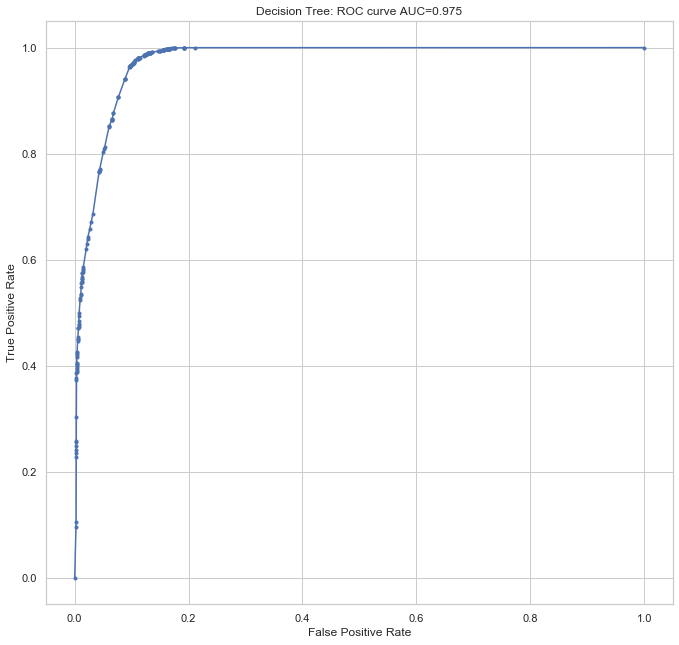

In [323]:
best_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                   max_features=None, max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=5, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, presort=False,
                                   random_state=None, splitter='best')

best_tree.fit(x_res, y_res)
y_pred = best_tree.predict(X_test)

print("Accuracy on training set: {:.3f}".format(best_tree.score(x_res, y_res)))
print("Accuracy on test set: {:.3f}".format(best_tree.score(X_test, y_test)))
show_accuracy(best_tree, X_test, y_test, "Decision Tree")

n_nodes = best_tree.tree_.node_count
children_left = best_tree.tree_.children_left
children_right = best_tree.tree_.children_right
feature = best_tree.tree_.feature
threshold = best_tree.tree_.threshold

Exporting a the results for visualization.  I recommend using [Webgraphviz](http://webgraphviz.com/) an online tool to read the picture generated by the model.

## Top 30 variables
The visual representation may become complex with multiple leafs and variations.  An approach can be a simple ranking of the variables by feature importance.  This yields a simple to understand graph that quantifies the absolute contribution of the variables.  The top 20 features are shown.

In [324]:
print(len(features_full.columns), len(best_tree.feature_importances_))
dt_feature_analysis = pd.DataFrame(
    {'Feature_names': features_full.columns, 'Feature_importances': best_tree.feature_importances_})
dt_feature_analysis.sort_values(
    by=['Feature_importances'], ascending=False, inplace=True)
dt_feature_analysis.head(30)

71 71


,Feature_names,Feature_importances
32,last_pymnt_amnt,0.354125
31,last_pmt_year,0.232361
66,total_rec_prncp,0.127606
33,loan_amnt,0.080865
65,total_rec_late_fee,0.050608
3,Maturity,0.036596
69,vintage,0.033884
28,inq_last_6mths,0.024618
24,funded_amnt,0.019430
30,int_rate,0.014389


## Feature importance visualization
The graph depicts the various variables and their relative explanatory contributions.

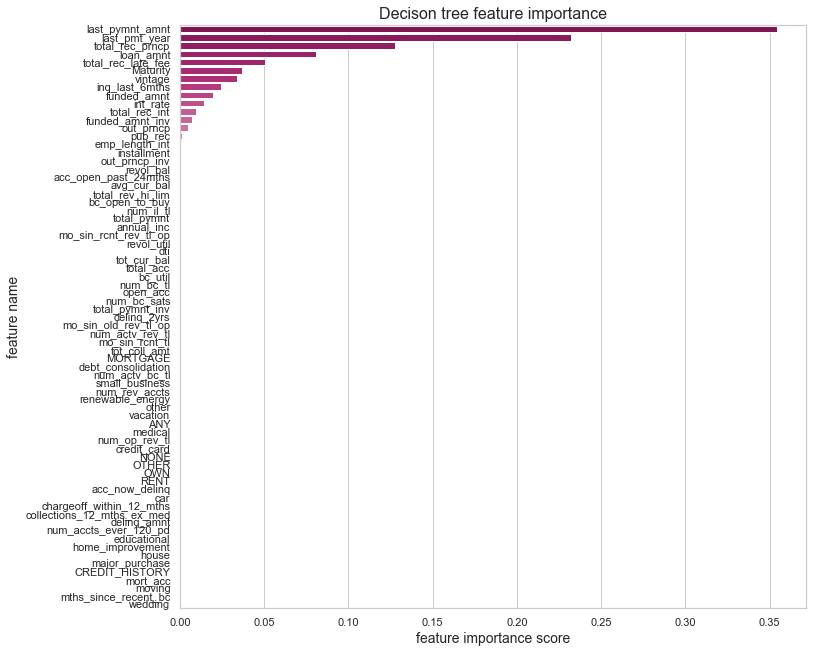

In [325]:
d_tree_graph = sns.barplot(
    x='Feature_importances', y='Feature_names', data=dt_feature_analysis, palette="PiYG")
d_tree_graph.set_title("Decison tree feature importance", fontsize=16)
d_tree_graph.set_xlabel("feature importance score", fontsize=14)
d_tree_graph.set_ylabel("feature name", fontsize=14)
plt.show()
plt.close()

In [326]:
print("Feature importances:\n{}".format(best_tree.feature_importances_))

Feature importances:
[0.00000000e+00 0.00000000e+00 9.55986615e-06 3.65955556e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.76042731e-05 5.13442751e-05 7.72262207e-05
 6.96713053e-05 3.71467487e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.10817032e-06 2.29326470e-05
 0.00000000e+00 4.50788632e-05 0.00000000e+00 7.73184372e-04
 1.94295782e-02 6.97242485e-03 0.00000000e+00 0.00000000e+00
 2.46176587e-02 6.23261496e-04 1.43892222e-02 2.32361165e-01
 3.54124852e-01 8.08652847e-02 0.00000000e+00 0.00000000e+00
 1.96945909e-05 4.73881971e-05 1.10226468e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.03130714e-06
 1.88106167e-05 2.73435001e-05 3.55218618e-05 6.64273928e-05
 0.00000000e+00 0.00000000e+00 3.33920316e-05 0.00000000e+00
 4.79310898e-03 2.80000429e-04 1.42658349e-03 0.00000000e+00
 1.43106156e-04 4.68452836e-05 0.00000000e+00 1.06231200e-05
 4.09650921e-05 3.86758184e-05 6.06379927e-05 2.61052956e-05
 9.

## Confusion matrix 
Although the model is not being used for prediction, the confusion matrix serves as a good tool for ensuring the predictive ability of the model just trained.

Accuracy0.9743952883642166


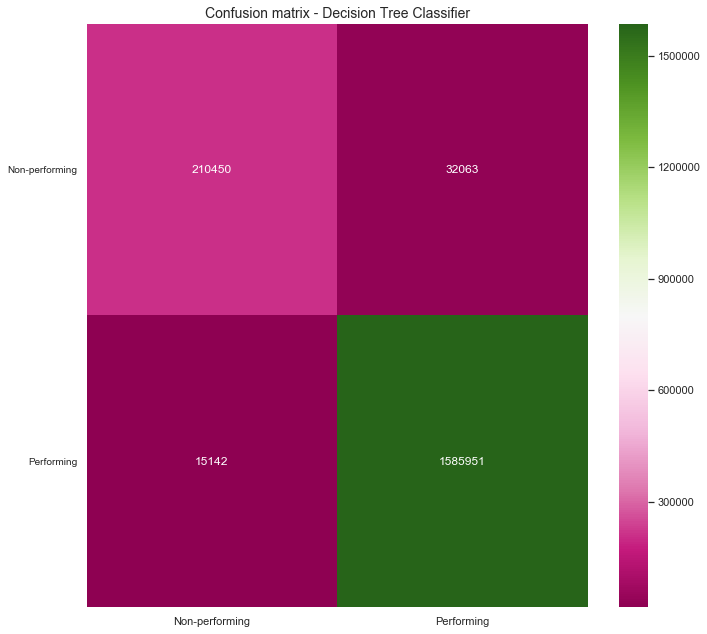

In [327]:
cm = confusion_matrix(y_test, y_pred)
cm1 = sns.heatmap(cm, fmt='d', annot=True, xticklabels=['Non-performing', 'Performing'],
                  yticklabels=['Non-performing', 'Performing'], cmap="PiYG")
cm1.set_yticklabels(cm1.get_yticklabels(), rotation=0, fontsize=10)
cm1.set_title("Confusion matrix - Decision Tree Classifier", fontsize=14)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

## Decision tree model based regression
It may be worth exploring the results of the decision tree model based regression to compare it with other models

In [328]:
dtr_tree = DecisionTreeRegressor().fit(x_res, y_res)
pred_tree = dtr_tree.predict(x_res)
dtr_tree.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')>

In [239]:
y_pred = dtr_tree.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(
    metrics.mean_squared_error(y_test, y_pred)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Mean Absolute Error: 0.039001974783533344
Mean Squared Error: 0.039001974783533344
Root Mean Squared Error: 0.19748917637058833
[[ 21244   3094]
 [  4095 155891]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     24338
           1       0.98      0.97      0.98    159986

    accuracy                           0.96    184324
   macro avg       0.91      0.92      0.92    184324
weighted avg       0.96      0.96      0.96    184324



Training the decision tree regression model 

# Random forest classifier
Random forest algorithm can be used for both classifications and regressions.  It does offer greater accuracy than decision trees and does not overfit the model.  Moreover, the classifer handles missing values and maintain accuracy even when the data is large.



Mean Absolute Error: 0.016796430473756323
Mean Squared Error: 0.016796430473756323
Root Mean Squared Error: 0.12960104349022936
Accuracy0.9832035695262437


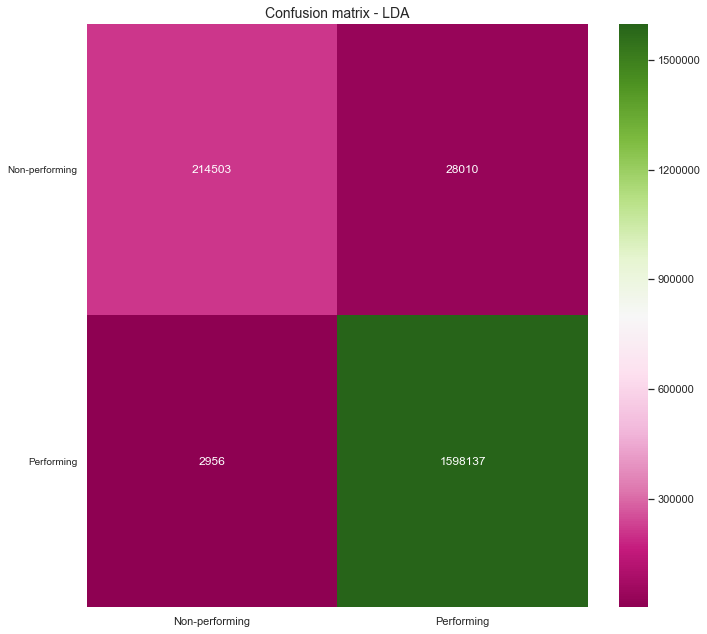

In [330]:
rf = RandomForestClassifier(n_estimators=30, n_jobs=-4)
rf.fit(x_res, y_res)
y_pred = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test, y_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(
    metrics.mean_squared_error(y_test, y_pred)))


cm = confusion_matrix(y_test, y_pred)
cm1 = sns.heatmap(cm, fmt='d', annot=True, xticklabels=['Non-performing', 'Performing'],
                  yticklabels=['Non-performing', 'Performing'], cmap="PiYG")
cm1.set_yticklabels(cm1.get_yticklabels(), rotation=0, fontsize=10)
cm1.set_title("Confusion matrix - LDA", fontsize=14)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

## Random forest feature contribution visualization
Show the importance of the various variables.

In [331]:
# Random forest model feature contribution visualization

rf_feature_importances = rf.feature_importances_
print(rf_feature_importances)

[6.28364804e-06 2.01253101e-03 5.64704877e-04 3.46514860e-02
 2.95109182e-07 4.67102061e-07 2.06406957e-03 4.39018552e-04
 3.86847285e-05 9.53755722e-03 2.80524916e-03 2.40832432e-03
 3.07927633e-03 2.27290647e-03 8.05905880e-05 1.39956617e-04
 2.09402618e-04 3.92877424e-03 7.01335525e-04 5.10186523e-03
 5.61070484e-05 2.44829921e-03 0.00000000e+00 1.16871232e-02
 2.76719807e-02 2.23218812e-02 7.96865309e-04 4.63870362e-05
 3.80191592e-02 1.99756480e-02 3.15673980e-02 1.18362036e-01
 1.36586281e-01 2.81056184e-02 1.78648684e-04 9.01588300e-05
 2.13007313e-03 2.22273263e-03 4.65203366e-03 2.11134695e-03
 5.60079011e-05 2.22168948e-03 7.17344967e-03 4.06393446e-03
 3.92156504e-03 3.97923349e-03 2.83603871e-03 2.00939268e-03
 2.18856595e-03 2.04039060e-03 1.84019142e-03 1.57375431e-03
 5.69900295e-02 5.60068224e-02 6.20120882e-03 1.07928451e-05
 2.60208274e-03 2.36995298e-03 7.16425951e-05 3.70103110e-03
 2.92802793e-03 1.91746482e-03 4.28330089e-02 3.79078206e-02
 1.28652622e-02 4.341682

In [332]:
print(len(features_full.columns), len(rf_feature_importances))
rf_feature_analysis = pd.DataFrame(
    {'Feature_names': features_full.columns, 'Feature_importances': rf_feature_importances})
rf_feature_analysis.sort_values(
    by=['Feature_importances'], ascending=False, inplace=True)
rf_feature_analysis.head(30)

71 71


,Feature_names,Feature_importances
32,last_pymnt_amnt,0.136586
66,total_rec_prncp,0.127390
31,last_pmt_year,0.118362
52,out_prncp,0.056990
53,out_prncp_inv,0.056007
69,vintage,0.047219
65,total_rec_late_fee,0.043417
62,total_pymnt,0.042833
28,inq_last_6mths,0.038019
63,total_pymnt_inv,0.037908


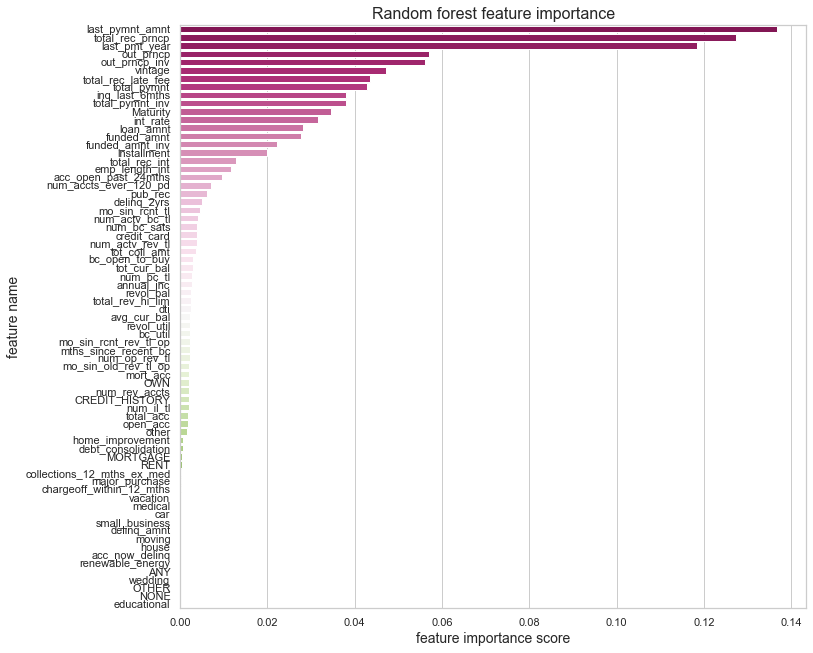

In [333]:
rf_tree_graph = sns.barplot(
    x='Feature_importances', y='Feature_names', data=rf_feature_analysis, palette="PiYG")
rf_tree_graph.set_title("Random forest feature importance", fontsize=16)
rf_tree_graph.set_xlabel("feature importance score", fontsize=14)
rf_tree_graph.set_ylabel("feature name", fontsize=14)
plt.show()
plt.close()

In [334]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93    217459
           1       1.00      0.98      0.99   1626147

    accuracy                           0.98   1843606
   macro avg       0.94      0.98      0.96   1843606
weighted avg       0.98      0.98      0.98   1843606



## Random forest regression
Finally, the performance of the random forest regression is assessed.

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/si

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/si

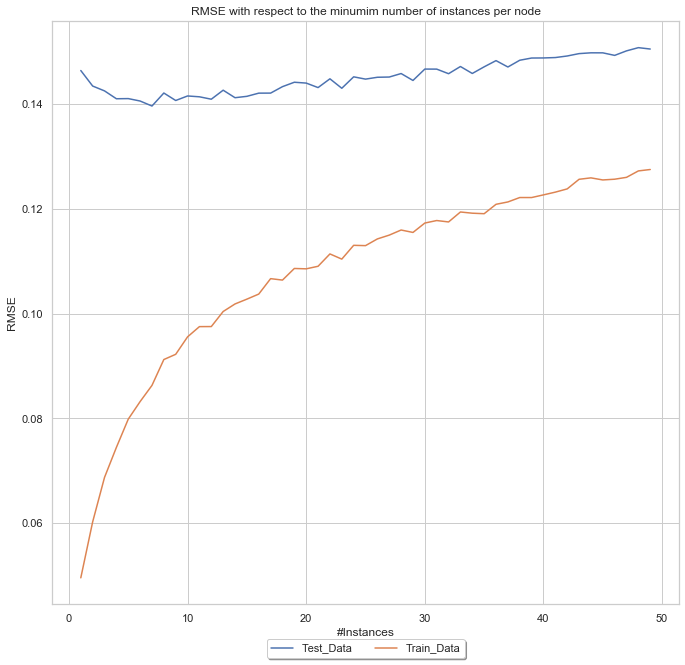

In [245]:
fig = plt.figure()
ax0 = fig.add_subplot(111)
RMSE_train = []
RMSE_test = []
for i in range(1, 50):
    # Paramterize the model and let i be the number of minimum instances per leaf node
    regression_model = RandomForestRegressor(
        criterion="mse", min_samples_leaf=i)
    # Train the model
    regression_model.fit(x_res, y_res)
    # Predict query instances
    predicted_train = regression_model.predict(x_res)
    predicted_test = regression_model.predict(X_test)
    # Calculate and append the RMSEs
    RMSE_train.append(
        np.sqrt(np.sum(((y_res-predicted_train)**2)/len(y_res))))
    RMSE_test.append(np.sqrt(np.sum(((y_test-predicted_test)**2)/len(y_test))))

ax0.plot(range(1, 50), RMSE_test, label='Test_Data')
ax0.plot(range(1, 50), RMSE_train, label='Train_Data')

ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
ax0.legend(loc='upper center', bbox_to_anchor=(
    0.5, -0.05), shadow=True, ncol=2)
plt.show()

plt.show()

# Conclusion
Based on the variables identified in the two models, the variables to pass onto the next steps are


In [340]:
dt_feature_analysis.columns = ['DT_feature', 'DT_importance']
rf_feature_analysis.columns = ['RF_feature', 'RF_importance']
feature_analysis = pd.concat(
    [dt_feature_analysis, rf_feature_analysis], axis=1)

feature_analysis['rank_DT'] = feature_analysis['DT_importance'].rank(
    ascending=True)
feature_analysis['rank_RF'] = feature_analysis['RF_importance'].rank(
    ascending=True)
feature_analysis['mean_rank'] = (
    feature_analysis['rank_DT'] + feature_analysis['rank_RF'])/2
feature_analysis['mean_importance'] = (
    feature_analysis['DT_importance']**2 + feature_analysis['RF_importance']**2)**0.5*100


In [351]:
pd.options.display.float_format = '{:.2f}'.format
feature_analysis.sort_values(by='mean_importance', axis=0, ascending=False).head(25)

,DT_feature,DT_importance,RF_feature,RF_importance,rank_DT,rank_RF,mean_rank,mean_importance
32,last_pymnt_amnt,0.35,last_pymnt_amnt,0.14,71.00,71.00,71.00,37.96
31,last_pmt_year,0.23,last_pmt_year,0.12,70.00,69.00,69.50,26.08
66,total_rec_prncp,0.13,total_rec_prncp,0.13,69.00,70.00,69.50,18.03
33,loan_amnt,0.08,loan_amnt,0.03,68.00,59.00,63.50,8.56
65,total_rec_late_fee,0.05,total_rec_late_fee,0.04,67.00,65.00,66.00,6.67
69,vintage,0.03,vintage,0.05,65.00,66.00,65.50,5.81
52,out_prncp,0.00,out_prncp,0.06,59.00,68.00,63.50,5.72
53,out_prncp_inv,0.00,out_prncp_inv,0.06,55.00,67.00,61.00,5.60
3,Maturity,0.04,Maturity,0.03,66.00,61.00,63.50,5.04
28,inq_last_6mths,0.02,inq_last_6mths,0.04,64.00,63.00,63.50,4.53


The analysis suggests that some of the most predicitive values are in fact ex post indicators of default or performance indicators.  Hence, the focus here is ex ante prediction, those variables should not be included in the next step of the analysis. These include:

- `last_pymnt_amnt`
- `last_pmt_year` 
- `total_rec_prncp` 
- `total_rec_late_fee`
- `total_rec_int`
- `funded_amnt_inv` 
- `installment`
- `out_prncp_inv`
- `funded_amnt`
- `total_pymnt`
- `tot_coll_amt`
- `out_prncp` 
- `delinq_amnt`
- `total_rec_int`
- `total_pymnt_inv`

Other variables that were eliminated from this modeling step are: `collection_recovery_fee`, `fico_range_high`, `recoveries`, `fico_range_low`, `last_fico_range_low`, `last_fico_range_high`. 

The rest of the variables can pass to the next step.


In [309]:
data_final = data1[{'PERFORMING', 'loan_amnt', 'Maturity', 'vintage', 'int_rate', 'CREDIT_HISTORY', 
                  'acc_open_past_24mths', 'collections_12_mths_ex_med', 'inq_last_6mths', 'annual_inc', 
                  'avg_cur_bal', 'dti', 'mo_sin_rcnt_tl', 'num_bc_tl', 'total_acc', 'emp_length_int', 
                  'open_acc', 'mort_acc', 'num_bc_sats', 'num_rev_accts', 'bc_open_to_buy', 
                  'mths_since_recent_bc', 'tot_cur_bal', 'num_il_tl', 'debt_consolidation', 
                  'num_accts_ever_120_pd', 'mo_sin_old_rev_tl_op', 'revol_util', 'revol_bal', 
                  'delinq_2yrs', 'num_actv_bc_tl', 'mo_sin_rcnt_rev_tl_op', 'pub_rec', 'num_actv_rev_tl', 
                  'total_rev_hi_lim', 'num_op_rev_tl', 'acc_now_delinq', 'bc_util', 
                  'chargeoff_within_12_mths', 'delinq_amnt', 'ANY', 'RENT', 'MORTGAGE', 'NONE', 'OTHER', 
                  'OWN', 'renewable_energy', 'vacation', 'small_business', 'medical', 'other', 'car', 
                  'credit_card', 'educational', 'home_improvement', 'house', 'major_purchase', 'moving', 
                  'wedding'}]

# save step 
data_final.to_csv('data/after_dt.csv')

In [305]:
# ENDS # ENDS # ENDS
#########################################################################################
# ENDS ####### (c) Peter Went, 2019
#########################################################################################